In [1]:
import qutip, pickle, sys
import matplotlib.pyplot as plt 
import numpy as np
import scipy.optimize as opt 
import scipy.linalg as linalg
import time as time
import math, cmath
import auxiliary_library as me

from IPython.display import display, Math, Latex
np.set_printoptions(threshold=1.e-9,linewidth=120,precision=3, suppress=True, formatter={"float":lambda x: str(.001*int(1000*x))})

In [13]:
def d_depth_proj_ev(Hamiltonian, ref_lagrange_op, depth_and_seed_ops, temp, ts, observables,
                    visualize_H_evs = False, 
                    visualize_Gram_m = False, 
                    visualize_nonherm = False,
                    visualize_expt_vals = True):
    
    ### building reference states and testing it
    start_time_1 = time.time()
    K_ref, rho_ref = me.build_reference_state(temp = temp_ref, 
                                              Hamiltonian = Hamiltonian,
                                              lagrange_op = ref_lagrange_op, 
                                              lagrange_mult = .5)
    
    basis_incursive = me.vectorized_recursive_basis(depth_and_ops=depth_and_seed_ops,                                             
                                                    Hamiltonian=Hamiltonian, 
                                                    rho0=rho_ref)
    
    basis_orth = me.base_orth(ops = basis_incursive, 
                              rho0 = rho_ref, 
                              sc_prod = me.HS_inner_prod_r, 
                              visualization = False, reinforce_reality=False)
    
    print("using a base of size ", len(basis_orth))
    print("rho_ref: ", rho_ref)
    ### test 2
    
    gram_matrix = me.basis_orthonormality_check(basis = basis_orth, 
                                  rho0 = rho_ref, 
                                  sc_prod = me.HS_inner_prod_r,
                                  visualization_Gram_m = True)
    
    ### constructing the initial state and H-tensor
    phi0, rho0 = me.build_rho0_from_basis(basis = basis_orth, temp=temp)
    Hijtensor = me.H_ij_matrix(Hamiltonian = Hamiltonian,
                               basis = basis_orth, 
                               rho0 = rho_ref, 
                               sc_prod = me.HS_inner_prod_r)
   
    ### constructing the coefficient arrays and the physical states
    rhot_list, phit = me.semigroup_phit_and_rhot_sol(phi0 = phi0, rho0 = rho0, 
                                                     Htensor = Hijtensor, ts = ts, 
                                                     basis = basis_orth)

    ### test 3
    herm_rhot_list = me.semigroup_rhos_test(rho_list = rhot_list, 
                                           visualization_nonherm = visualize_nonherm, ts = ts)
    
    ### Projected solution
    
    res_proj_ev = [np.array([qutip.expect(obs, rhot) for rhot in rhot_list]) for obs in observables]
    print("Proj ev runtime = ", time.time() - start_time_1)
    
    ### Exact solution 
    
    start_time_2 = time.time()
    res_exact = me.mesolve(Hamiltonian, rho0=rho0, tlist=ts, c_ops=None, e_ops=observables)
    
    print("Exact ev runtime = ", time.time() - start_time_2)
    
    if visualize_expt_vals:
        me.plot_exact_v_proj_ev_avgs(observables, label_ops, ts, res_proj_ev, res_exact)
        label_metric = ["Bures Exact v. Proj ev", "S(exact || proj_ev)", "S(proj_ev || exact)"]
        me.plot_exact_v_proj_ev_metrics(ts, res_proj_ev, res_exact, label_metric)
        
    return Gram_matrix, rho0, rhot_list, res_exact, res_proj_ev, rhot_list, basis_orth, phit

In [14]:
N=3; chain_type = "XYZ"; 

### Construcción de los operadores
spin_ops_list = me.one_body_spin_ops(N)
identity_op = spin_ops_list[0][0]

### Heisenberg Hamiltonian
Hamiltonian_paras = [.2, .15, .1, 1.]
H_H = me.Heisenberg_Hamiltonian(op_list = spin_ops_list, chain_type = chain_type,
                                size = N, Hamiltonian_paras = Hamiltonian_paras,
                                closed_bcs = True, visualization = False)

#rho_tolerance = (-.5 * H_H).expm(); #rho_tolerance = rho_tolerance/rho_tolerance.tr()
#sigma_tolerance = (-.4 * H_H).expm(); #sigma_tolerance = sigma_tolerance/sigma_tolerance.tr()

### classical operators 

cl_ops, label_ops = me.classical_ops(H_H, N, spin_ops_list, False)
magnetization = sum(spin_ops_list[3][a] for a in range(len(spin_ops_list[3])))
neel_operator = sum((-1)**a * spin_ops_list[3][a] for a in range(len(spin_ops_list[3])))

cl_ops["magnetization"] = magnetization; label_ops.append("magnetization")
cl_ops["neel_op"] = neel_operator; label_ops.append("neel_op")
print("Are all the operators Hermitian?:", me.basis_hermitian_check(cl_ops))

### Base completa

zero_body_ops = spin_ops_list[0]
one_body_ops = [op for op in spin_ops_list[1]+spin_ops_list[2]+spin_ops_list[3]]
two_body_ops = [op1 * op2 for op1 in one_body_ops for op2 in one_body_ops]
three_body_ops = [op1 * op2 * op3 for op1 in one_body_ops for op2 in one_body_ops for op3 in one_body_ops]

depth_and_seed_ops = [(1,op) for op in (zero_body_ops + one_body_ops + two_body_ops)]
print(len(depth_and_seed_ops))

Are all the operators Hermitian?: [True, True, True, True, True, True, True, True, True, True]
91


using a base of size  37
rho_ref:  Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[0.335 0.0 0.0 ... 0.014 0.002 0.0]
 [0.0 0.312 0.023 ... 0.0 0.0 0.002]
 [0.0 0.023 0.078 ... 0.0 0.0 0.003]
 ...
 [0.014 0.0 0.0 ... 0.078 0.005 0.0]
 [0.002 0.0 0.0 ... 0.005 0.013000000000000001 0.0]
 [0.0 0.002 0.003 ... 0.0 0.0 0.014]]
The basis is orthonormal and hermitian
Proj ev runtime =  10.267061471939087
Exact ev runtime =  0.043032169342041016


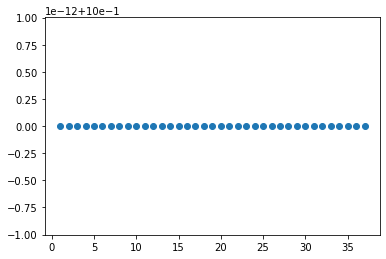

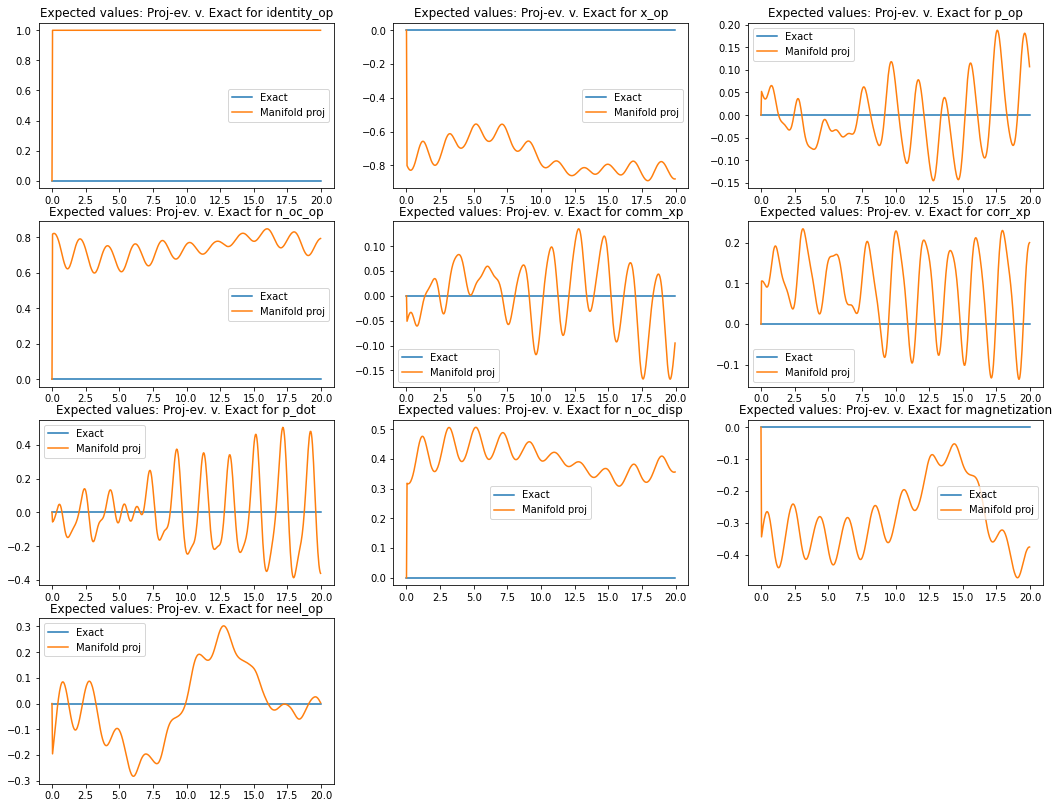

AssertionError: Lists not of the same length

In [15]:
observables = list(cl_ops.values())
Gram_matrix, rho0, rhot_list, res_exact, res_proj_ev, rhot_list, basis_orth, phit = d_depth_proj_ev(
    Hamiltonian = H_H, ref_lagrange_op = cl_ops["n_oc_disp"], 
    depth_and_seed_ops = depth_and_seed_ops,
    temp = temp, ts = ts, observables = observables,
    visualize_H_evs = False,
    visualize_Gram_m = True,
    visualize_nonherm = False,
    visualize_expt_vals = True)

# Cosas para testear:

1. dos operadores con índices de recursividad d1 y d2, le ganan a un único operador de índice (d1+d2)?
2. como cuantificar el "poder" o el operador que más domina en la expansión? lambda más grande?
3. tiene sentido usar el algoritmo de Strassen acá?
4. plotear Bures y entropías relativas entre estados
5. intentar con funciones de dos puntos y Neels/Magnetizations